# Cifar10 - exercicio de classificar 3 classes no PyTorch

Refazer o exercício da week05, porém agora utilizando o PyTorch

Para quem estiver já habituado no uso do PyTorch este exercício pode ser trocado pelo:

1. Fazer o transfer learning do Cifar (exercício da week06
2. Fazer otimização para calcular uma imagem sintética com pixels otimizados para que a probabilidade de uma classe (à sua escolha) seja maximizada.

Tenho um exemplo ainda em desenvolvimento em https://t-adessowiki.fee.unicamp.br/user/lotufo/notebooks/lotufo/ia368z/deliver-pytorch/transfer_learning_tutorial.ipynb

que pode ser utilizado como inspiração. Estou procurando outros também.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt

import numpy as np
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from time import time
from torch.autograd import Variable

## Carregando dados

In [2]:
data = np.load('/etc/jupyterhub/ia368z_2s2017/datasets/cifar10-redux.npz')

Para maior rapidez na depuração do programa, reduza o número de amostras para bem pouco, digamos 100 para treino e 50 para validação. Depois que estiver tudo testado, coloque few_samples como False para utilizar as 2000 amostras e deixe o treinamento completo ocorrer.

In [3]:
few_samples = False
if few_samples:
    n_samples = 100
else:
    n_samples = 2000

In [4]:
X = data['X_train'][:n_samples]
y = data['y_train'][:n_samples]
X_test = data['X_test'][:n_samples]
y_test = data['y_test'][:n_samples]

In [5]:
X.shape, y.shape, X_test.shape, y_test.shape

((2000, 3, 32, 32), (2000,), (500, 3, 32, 32), (500,))

## Normalização dos dados

In [6]:
X = X.astype('float32')
X /= 255.
X_test = X_test.astype('float32')
X_test /= 255.

y -= y.min()
y_test -= y_test.min()

## Divisão dos dados em treino e validação

In [7]:
# numero de amostras
nb_data = X.shape[0]

# semente fixa para dar reproducibilidade
seed = 13
np.random.seed(seed)

msk = np.random.rand(nb_data) < 0.80
X_train = X[msk]
X_validate = X[~msk]
y_train = y[msk]
y_validate = y[~msk]

print(X_train.shape)
print(X_validate.shape)
print(y_train.shape)
print(y_validate.shape)

(1605, 3, 32, 32)
(395, 3, 32, 32)
(1605,)
(395,)


## Cria DataLoader

In [8]:
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)

X_validate = torch.from_numpy(X_validate).type(torch.FloatTensor)
y_validate = torch.from_numpy(y_validate).type(torch.LongTensor)

X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

train = torch.utils.data.TensorDataset(X_train, y_train)

train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=50,
                                          shuffle=True,
                                          num_workers=2)

validate = torch.utils.data.TensorDataset(X_validate, y_validate)

validate_loader = torch.utils.data.DataLoader(validate,
                                          batch_size=50,
                                          shuffle=True,
                                          num_workers=2)

test = torch.utils.data.TensorDataset(X_test, y_test)

test_loader = torch.utils.data.DataLoader(test,
                                         batch_size=500,
                                         shuffle=False,
                                         num_workers=2)

## Define a classe da rede

In [9]:
import torch.nn.functional as F

class Net1(torch.nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 3)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.drop1 = torch.nn.Dropout(0.25)
        
        self.conv3 = torch.nn.Conv2d(64, 48, 3)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.drop2 = torch.nn.Dropout(0.25)
        
        self.dense1 = torch.nn.Linear(48 * 6 * 6, 128)
        self.drop3 = torch.nn.Dropout(0.75)
        self.dense2 = torch.nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = x.view(-1, 48 * 6 * 6)
        x = F.relu(self.dense1(x))
        x = self.drop3(x)
        x = self.dense2(x)
        return x

In [10]:
class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Cria a rede

In [11]:
net = Net1()
print(net)

Net1 (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (drop1): Dropout (p = 0.25)
  (conv3): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (drop2): Dropout (p = 0.25)
  (dense1): Linear (1728 -> 128)
  (drop3): Dropout (p = 0.75)
  (dense2): Linear (128 -> 3)
)


In [12]:
def prediction(loader, model, loss_fn):
    correct = 0
    total = 0
    for data in loader:
        images, labels = data
        
        # forward pass
        outputs = model(Variable(images))
        
        # cálculo da acurácia
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
        # loss
        loss = loss_fn(outputs, Variable(labels))
        
    return ((100 * correct / total), loss.data[0])

## Treina a rede

In [13]:
import copy

epochs = 100 
last_epoch = epochs - 1
patience = 10
patience_count = 0
best_model = []
best_val_acc = 0
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

# histórico de acurácia e perda
train_loss = np.empty(epochs)
val_loss = np.empty(epochs)
train_acc = np.empty(epochs)
val_acc = np.empty(epochs)
    
for t in range(epochs):
    start_time = time()
    for i, data in enumerate(train_loader, 0):
        # pega entradas
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        # forward pass
        predict = net(inputs)

        # loss
        loss = loss_fn(predict, labels)

        # zera gradiente
        optimizer.zero_grad()
            
        # calcula novos gradientes
        loss.backward()

        # atualiza pesos
        optimizer.step()

    elapsed_time = time() - start_time
    # acurácia e perda o conjunto de treinamento
    train_acc[t], train_loss[t] = prediction(train_loader, net, loss_fn)
    # acurácia e perda no conjunto de validação
    val_acc[t], val_loss[t] = prediction(validate_loader, net, loss_fn)
    # imprime dados do treinamento
    print('Epoch:', t, '-',round(elapsed_time,0),'s',
          '\t train loss:', round(train_loss[t],5), 
          '\t val loss:', round(val_loss[t],5),
          '\t train acc:', round(train_acc[t], 5),  
          '\t val acc:', round(val_acc[t], 5))

    # verifica melhora do modelo
    if(best_val_acc < val_acc[t]):
        patience_count = 0
        best_val_acc = val_acc[t]
        best_model = copy.deepcopy(net)

    # early stop
    if(patience_count > patience):
        print('Early stopping as accuracy did not improve on last', patience, 'epochs!')
        last_epoch = t
        break;

    patience_count += 1

# recupera melhor modelo
net = best_model
print('Trainning completed!')

Epoch:  0 - 9.0 s 	 train loss:  1.08408 	 val loss:  1.1035 	 train acc:  35.2648 	 val acc:  34.93671
Epoch:  1 - 9.0 s 	 train loss:  0.95012 	 val loss:  1.05664 	 train acc:  43.05296 	 val acc:  36.4557
Epoch:  2 - 8.0 s 	 train loss:  1.16871 	 val loss:  1.06954 	 train acc:  39.00312 	 val acc:  46.32911
Epoch:  3 - 10.0 s 	 train loss:  0.43964 	 val loss:  1.0826 	 train acc:  51.40187 	 val acc:  48.10127
Epoch:  4 - 10.0 s 	 train loss:  1.09081 	 val loss:  1.04202 	 train acc:  52.33645 	 val acc:  50.37975
Epoch:  5 - 11.0 s 	 train loss:  0.76278 	 val loss:  1.09794 	 train acc:  54.51713 	 val acc:  55.94937
Epoch:  6 - 9.0 s 	 train loss:  0.46091 	 val loss:  0.96845 	 train acc:  57.6324 	 val acc:  52.40506
Epoch:  7 - 11.0 s 	 train loss:  0.97858 	 val loss:  0.90614 	 train acc:  59.75078 	 val acc:  56.20253
Epoch:  8 - 10.0 s 	 train loss:  0.52505 	 val loss:  1.0351 	 train acc:  60.37383 	 val acc:  52.91139
Epoch:  9 - 10.0 s 	 train loss:  1.007 	 val l

## Avaliação do erro

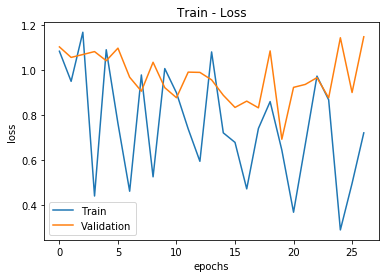

In [14]:
plt.title('Train - Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(train_loss[:last_epoch], label='Train')
plt.plot(val_loss[:last_epoch], label='Validation')
plt.legend()
plt.show()

## Avaliação da acurácia

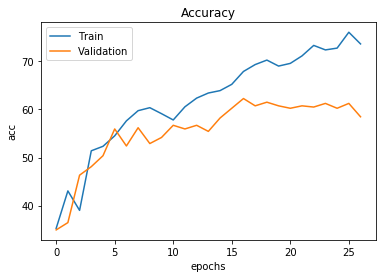

In [15]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.plot(train_acc[:last_epoch], label='Train')
plt.plot(val_acc[:last_epoch], label='Validation')
plt.legend()
plt.show()

## Acurácia da rede

In [33]:
test_acc, test_loss = prediction(test_loader, net, loss_fn)
print('Accuracy:', round(test_acc, 5), 
      '\t Loss:', round(test_loss, 5))

Accuracy: 60.4 	 Loss: 0.8831
